# Setup

Lattice: MxM matrix with entries $N_i$
Update rule for $N_i$: $N_i^{(t+1)} = N_i^{t} + r N_i^{t}(1 - \frac{N_i^{t}}{P_i}) \Delta t$
Parameters: $r, \Delta t$

$P_i$ is the productivity and depends on the "match" between Environment $E_i$ and Population skills $G_i$. Both are binary vectors.
We have $P_i = P_0 < E_i, G_i >$.

Questions: Initial population? Random? Choice of R? What do we actually want to see (compare different cell, a certain form of N), etc.

Talk to Daniel: Initialize lattice with non-zero entry in upper-left edge. Keep population growth according to a logistic function (which is fair enough). For spatial correlation of the environment, use either Perlin noise OR move through the lattice and have a minor chance to CHANGE the value of the environment while moving. Introduce fission probability and move around.

For the basic variant, we observe a sigmoid (solution of the logistic equation). The "squishing" depends on the productivity, and the initial population level as expected.

Do we really want a binary vector? Spatial correlation might be difficult to achieve, and is perhaps unrealistic. Probably not. Just normalize the thing in the end.

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import noise

In [69]:
# Parameters
M = 100 # size of lattice (1D)
num_vars = 10 # length of envs vector)
p_0 = 200 # Basic productivity

# Random number generator
seed = 50
rng = np.random.default_rng(seed=seed)

In [113]:
# Set up the environment
envs = np.empty((M, M, num_vars))
skills = np.empty((M, M, num_vars)) # skills of the population
productivity = np.empty((M, M)) # productivity

# Populate with random values
for i in range(M):
    for j in range(M):
        envs[i, j] = rng.integers(size=num_vars, low=0, high=1, endpoint=True)
        skills[i, j] = rng.integers(size=num_vars, low=0, high=1, endpoint=True)
        productivity[i, j] = p_0 * np.dot(envs[i, j], skills[i, j])

# Populate environment with spatially correlated variables
envs_perlin = np.empty_like(envs)
scale = 0.1
for i in range(M):
    for j in range(M):
        perlin_noise = [noise.pnoise3(i * scale, j * scale, k * scale) for k in range(num_vars)]
        envs_perlin[i, j] = perlin_noise

# Binarize the noise (now distributed around zero)
ones = [1 for _ in range(num_vars)]
zeros = [0 for _ in range(num_vars)]
for i in range(num_vars):
    envs_perlin[:, :, i] = np.where(envs_perlin[:, :, i] > 0, 1, 0)

# Perlin noise yields a dynamic output
# Method from Daniel:
p_switch = 0.05
envs_gradual = np.empty((M, M, num_vars))
envs_gradual[0, 0] = [1 for _ in range(num_vars)]

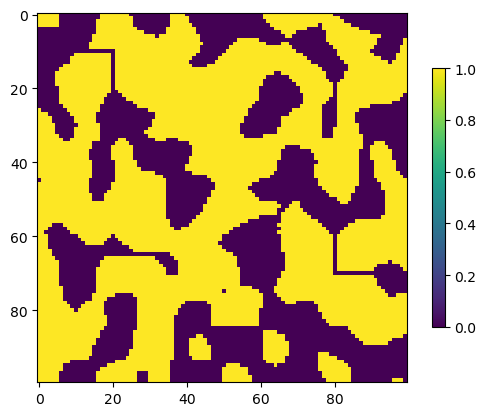

In [115]:
# Visualize productivity
fig = plt.figure()
plot = plt.imshow(envs_perlin[:, :, 5])
fig.colorbar(plot, shrink=0.7)

In [86]:
# Updating the population dynamics
time_steps = 10_000
r = 1 / 400 # Growth coefficient in equation (1)

pop_t = np.empty((time_steps, M, M))
# pop_0 = rng.integers(size=(M, M), low=0, high=100)
pop_0 = np.empy((M, M))
pop_0[0, 0] = 1 # populate upper-left edge
pop_t[0] = pop_0

for i in range(1, time_steps):
    pop_t[i] = pop_t[i-1] + r * pop_t[i-1] * (1 - pop_t[i-1] / productivity)

C:\Users\leoko\AppData\Local\Temp\ipykernel_22520\1380118956.py:10: RuntimeWarning: divide by zero encountered in divide
  pop_t[i] = pop_t[i-1] + r * pop_t[i-1] * (1 - pop_t[i-1] / productivity)
C:\Users\leoko\AppData\Local\Temp\ipykernel_22520\1380118956.py:10: RuntimeWarning: invalid value encountered in divide
  pop_t[i] = pop_t[i-1] + r * pop_t[i-1] * (1 - pop_t[i-1] / productivity)


Text(0.5, 1.0, 'Population dynamics for a selected cell')

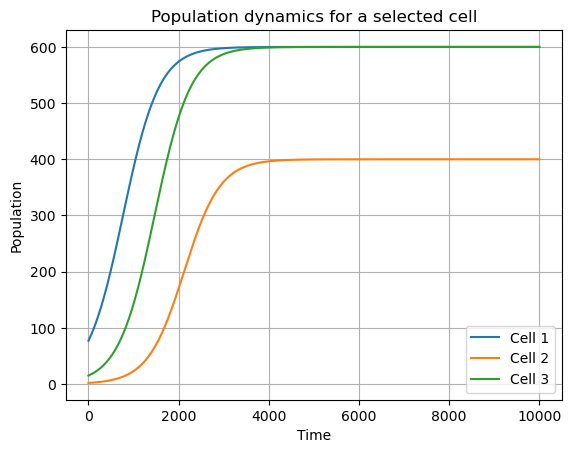

In [94]:
plt.plot(pop_t[:, 20, 28], label="Cell 1")
plt.plot(pop_t[:, 21, 28], label="Cell 2")
plt.plot(pop_t[:, 22, 28], label="Cell 3")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Population")
plt.grid()
plt.title("Population dynamics for a selected cell")